# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (SentiWS) most highly correlated with GDP growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast GDP growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, SentiWS (<=2007, 200 topics, all sources).
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                             # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11511
EM converged at iteration 84, llf=-11255, convergence criterion=9.8202e-07 < tolerance=1e-06
EM start iterations, llf=-11524
EM converged at iteration 84, llf=-11267, convergence criterion=9.8076e-07 < tolerance=1e-06
EM start iterations, llf=-11577
EM converged at iteration 85, llf=-11318, convergence criterion=9.7687e-07 < tolerance=1e-06
EM start iterations, llf=-11586
EM converged at iteration 84, llf=-11326, convergence criterion=9.9102e-07 < tolerance=1e-06
EM start iterations, llf=-11647
EM converged at iteration 84, llf=-11382, convergence criterion=9.811e-07 < tolerance=1e-06
EM start iterations, llf=-11655
EM converged at iteration 84, llf=-11389, convergence criterion=9.8039e-07 < tolerance=1e-06
EM start iterations, llf=-11709
EM converged at iteration 84, llf=-11444, convergence criterion=9.9797e-07 < tolerance=1e-06
EM start iterations, llf=-11709
EM converged at iteration 84, llf=-11444, convergence criterion=9.9797e-07 < tolerance=1e-06
E

EM start iterations, llf=-13128
EM converged at iteration 66, llf=-12930, convergence criterion=9.9919e-07 < tolerance=1e-06
EM start iterations, llf=-13187
EM converged at iteration 65, llf=-13000, convergence criterion=9.7643e-07 < tolerance=1e-06
EM start iterations, llf=-13194
EM converged at iteration 66, llf=-13004, convergence criterion=9.8118e-07 < tolerance=1e-06
EM start iterations, llf=-13247
EM converged at iteration 66, llf=-13052, convergence criterion=9.7831e-07 < tolerance=1e-06
EM start iterations, llf=-13247
EM converged at iteration 66, llf=-13052, convergence criterion=9.7831e-07 < tolerance=1e-06
EM start iterations, llf=-13259
EM converged at iteration 66, llf=-13065, convergence criterion=9.8216e-07 < tolerance=1e-06
EM start iterations, llf=-13309
EM converged at iteration 65, llf=-13118, convergence criterion=9.8563e-07 < tolerance=1e-06
EM start iterations, llf=-13316
EM converged at iteration 66, llf=-13125, convergence criterion=9.7792e-07 < tolerance=1e-06


EM start iterations, llf=-14825
EM converged at iteration 65, llf=-14616, convergence criterion=9.7614e-07 < tolerance=1e-06
EM start iterations, llf=-14825
EM converged at iteration 65, llf=-14616, convergence criterion=9.7614e-07 < tolerance=1e-06
EM start iterations, llf=-14834
EM converged at iteration 65, llf=-14626, convergence criterion=9.7588e-07 < tolerance=1e-06
EM start iterations, llf=-14885
EM converged at iteration 65, llf=-14677, convergence criterion=9.7224e-07 < tolerance=1e-06
EM start iterations, llf=-14898
EM converged at iteration 65, llf=-14689, convergence criterion=9.7169e-07 < tolerance=1e-06
EM start iterations, llf=-14946
EM converged at iteration 65, llf=-14737, convergence criterion=9.7173e-07 < tolerance=1e-06
EM start iterations, llf=-14953
EM converged at iteration 65, llf=-14744, convergence criterion=9.7178e-07 < tolerance=1e-06
EM start iterations, llf=-14999
EM converged at iteration 65, llf=-14789, convergence criterion=9.8237e-07 < tolerance=1e-06


EM start iterations, llf=-16500
EM converged at iteration 58, llf=-16263, convergence criterion=9.9113e-07 < tolerance=1e-06
EM start iterations, llf=-16506
EM converged at iteration 59, llf=-16269, convergence criterion=9.6898e-07 < tolerance=1e-06
EM start iterations, llf=-16558
EM converged at iteration 58, llf=-16321, convergence criterion=9.8758e-07 < tolerance=1e-06
EM start iterations, llf=-16564
EM converged at iteration 58, llf=-16327, convergence criterion=9.9009e-07 < tolerance=1e-06
EM start iterations, llf=-16620
EM converged at iteration 58, llf=-16383, convergence criterion=9.7859e-07 < tolerance=1e-06
EM start iterations, llf=-16620
EM converged at iteration 58, llf=-16383, convergence criterion=9.7859e-07 < tolerance=1e-06
EM start iterations, llf=-16629
EM converged at iteration 58, llf=-16392, convergence criterion=9.7175e-07 < tolerance=1e-06
EM start iterations, llf=-16680
EM converged at iteration 58, llf=-16443, convergence criterion=9.6749e-07 < tolerance=1e-06


EM start iterations, llf=-17976
EM converged at iteration 53, llf=-17731, convergence criterion=9.7258e-07 < tolerance=1e-06
EM start iterations, llf=-18034
EM converged at iteration 53, llf=-17787, convergence criterion=9.766e-07 < tolerance=1e-06
EM start iterations, llf=-18034
EM converged at iteration 53, llf=-17787, convergence criterion=9.766e-07 < tolerance=1e-06
EM start iterations, llf=-18040
EM converged at iteration 53, llf=-17792, convergence criterion=9.7635e-07 < tolerance=1e-06
EM start iterations, llf=-18093
EM converged at iteration 53, llf=-17844, convergence criterion=9.7852e-07 < tolerance=1e-06
EM start iterations, llf=-18100
EM converged at iteration 54, llf=-17852, convergence criterion=9.6838e-07 < tolerance=1e-06
EM start iterations, llf=-18155
EM converged at iteration 54, llf=-17905, convergence criterion=9.6963e-07 < tolerance=1e-06
EM start iterations, llf=-18163
EM converged at iteration 54, llf=-17912, convergence criterion=9.6879e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11871
EM iteration 100, llf=-11588, convergence criterion=1.0063e-06
EM converged at iteration 101, llf=-11588, convergence criterion=9.8791e-07 < tolerance=1e-06
EM start iterations, llf=-11880
EM iteration 100, llf=-11596, convergence criterion=1.0108e-06
EM converged at iteration 101, llf=-11596, convergence criterion=9.9236e-07 < tolerance=1e-06
EM start iterations, llf=-11926
EM converged at iteration 99, llf=-11643, convergence criterion=9.9686e-07 < tolerance=1e-06
EM start iterations, llf=-11939
EM converged at iteration 87, llf=-11658, convergence criterion=9.9772e-07 < tolerance=1e-06
EM start iterations, llf=-11979
EM converged at iteration 85, llf=-11694, convergence criterion=9.8885e-07 < tolerance=1e-06
EM start iterations, llf=-11990
EM converged at iteration 85, llf=-11706, convergence criterion=9.9304e-07 < tolerance=1e-06
EM start iterations, llf=-12075
EM converged at iteration 85, llf=-11794, convergence criterion=9.9153e-07 < tolerance=1e-

EM iteration 100, llf=-13256, convergence criterion=1.0068e-06
EM converged at iteration 101, llf=-13256, convergence criterion=9.9168e-07 < tolerance=1e-06
EM start iterations, llf=-13493
EM iteration 100, llf=-13302, convergence criterion=1.0683e-06
EM converged at iteration 105, llf=-13302, convergence criterion=9.9188e-07 < tolerance=1e-06
EM start iterations, llf=-13501
EM iteration 100, llf=-13309, convergence criterion=1.0249e-06
EM converged at iteration 102, llf=-13309, convergence criterion=9.9428e-07 < tolerance=1e-06
EM start iterations, llf=-13547
EM iteration 100, llf=-13352, convergence criterion=1.0059e-06
EM converged at iteration 101, llf=-13352, convergence criterion=9.9083e-07 < tolerance=1e-06
EM start iterations, llf=-13558
EM iteration 100, llf=-13364, convergence criterion=1.0601e-06
EM converged at iteration 104, llf=-13364, convergence criterion=9.9858e-07 < tolerance=1e-06
EM start iterations, llf=-13604
EM iteration 100, llf=-13415, convergence criterion=1.2

EM start iterations, llf=-14944
EM converged at iteration 94, llf=-14735, convergence criterion=9.8922e-07 < tolerance=1e-06
EM start iterations, llf=-14952
EM converged at iteration 93, llf=-14742, convergence criterion=9.9856e-07 < tolerance=1e-06
EM start iterations, llf=-14998
EM converged at iteration 94, llf=-14786, convergence criterion=9.8892e-07 < tolerance=1e-06
EM start iterations, llf=-14998
EM converged at iteration 94, llf=-14786, convergence criterion=9.8892e-07 < tolerance=1e-06
EM start iterations, llf=-15010
EM converged at iteration 94, llf=-14799, convergence criterion=9.9973e-07 < tolerance=1e-06
EM start iterations, llf=-15050
EM converged at iteration 93, llf=-14838, convergence criterion=9.9712e-07 < tolerance=1e-06
EM start iterations, llf=-15060
EM converged at iteration 92, llf=-14846, convergence criterion=9.8757e-07 < tolerance=1e-06
EM start iterations, llf=-15118
EM converged at iteration 91, llf=-14900, convergence criterion=9.9613e-07 < tolerance=1e-06


EM start iterations, llf=-16618
EM converged at iteration 70, llf=-16379, convergence criterion=9.8129e-07 < tolerance=1e-06
EM start iterations, llf=-16627
EM converged at iteration 70, llf=-16389, convergence criterion=9.8408e-07 < tolerance=1e-06
EM start iterations, llf=-16679
EM converged at iteration 70, llf=-16440, convergence criterion=9.9522e-07 < tolerance=1e-06
EM start iterations, llf=-16689
EM converged at iteration 70, llf=-16451, convergence criterion=9.9945e-07 < tolerance=1e-06
EM start iterations, llf=-16744
EM converged at iteration 71, llf=-16506, convergence criterion=9.857e-07 < tolerance=1e-06
EM start iterations, llf=-16757
EM converged at iteration 71, llf=-16519, convergence criterion=9.8634e-07 < tolerance=1e-06
EM start iterations, llf=-16810
EM converged at iteration 70, llf=-16575, convergence criterion=9.9926e-07 < tolerance=1e-06
EM start iterations, llf=-16810
EM converged at iteration 70, llf=-16575, convergence criterion=9.9926e-07 < tolerance=1e-06
E

EM start iterations, llf=-18099
EM converged at iteration 59, llf=-17848, convergence criterion=9.8273e-07 < tolerance=1e-06
EM start iterations, llf=-18154
EM converged at iteration 59, llf=-17901, convergence criterion=9.8078e-07 < tolerance=1e-06
EM start iterations, llf=-18162
EM converged at iteration 59, llf=-17908, convergence criterion=9.813e-07 < tolerance=1e-06
EM start iterations, llf=-18218
EM converged at iteration 60, llf=-17962, convergence criterion=9.7438e-07 < tolerance=1e-06
EM start iterations, llf=-18218
EM converged at iteration 60, llf=-17962, convergence criterion=9.7438e-07 < tolerance=1e-06
EM start iterations, llf=-18223
EM converged at iteration 59, llf=-17965, convergence criterion=9.9959e-07 < tolerance=1e-06
EM start iterations, llf=-18279
EM converged at iteration 59, llf=-18023, convergence criterion=9.9936e-07 < tolerance=1e-06
EM start iterations, llf=-18285
EM converged at iteration 59, llf=-18027, convergence criterion=9.9978e-07 < tolerance=1e-06
E

EM start iterations, llf=-12164
EM converged at iteration 83, llf=-11920, convergence criterion=9.8595e-07 < tolerance=1e-06
EM start iterations, llf=-12161
EM converged at iteration 85, llf=-11925, convergence criterion=9.9326e-07 < tolerance=1e-06
EM start iterations, llf=-12161
EM converged at iteration 85, llf=-11925, convergence criterion=9.9326e-07 < tolerance=1e-06
EM start iterations, llf=-12168
EM converged at iteration 86, llf=-11942, convergence criterion=9.8797e-07 < tolerance=1e-06
EM start iterations, llf=-12198
EM converged at iteration 86, llf=-11978, convergence criterion=9.8532e-07 < tolerance=1e-06
EM start iterations, llf=-12201
EM converged at iteration 86, llf=-11987, convergence criterion=9.9337e-07 < tolerance=1e-06
EM start iterations, llf=-12237
EM converged at iteration 86, llf=-12035, convergence criterion=9.8616e-07 < tolerance=1e-06
EM start iterations, llf=-12270
EM converged at iteration 87, llf=-12074, convergence criterion=9.8204e-07 < tolerance=1e-06


EM start iterations, llf=-13747
EM converged at iteration 95, llf=-13555, convergence criterion=9.829e-07 < tolerance=1e-06
EM start iterations, llf=-13799
EM converged at iteration 95, llf=-13606, convergence criterion=9.8624e-07 < tolerance=1e-06
EM start iterations, llf=-13806
EM converged at iteration 93, llf=-13612, convergence criterion=9.8247e-07 < tolerance=1e-06
EM start iterations, llf=-13861
EM converged at iteration 92, llf=-13667, convergence criterion=9.8856e-07 < tolerance=1e-06
EM start iterations, llf=-13871
EM converged at iteration 92, llf=-13677, convergence criterion=9.8871e-07 < tolerance=1e-06
EM start iterations, llf=-13921
EM converged at iteration 92, llf=-13726, convergence criterion=9.9411e-07 < tolerance=1e-06
EM start iterations, llf=-13921
EM converged at iteration 92, llf=-13726, convergence criterion=9.9411e-07 < tolerance=1e-06
EM start iterations, llf=-13931
EM converged at iteration 92, llf=-13735, convergence criterion=9.9289e-07 < tolerance=1e-06
E

EM start iterations, llf=-15478
EM converged at iteration 87, llf=-15258, convergence criterion=9.9607e-07 < tolerance=1e-06
EM start iterations, llf=-15482
EM converged at iteration 87, llf=-15262, convergence criterion=9.9317e-07 < tolerance=1e-06
EM start iterations, llf=-15526
EM converged at iteration 87, llf=-15306, convergence criterion=9.9992e-07 < tolerance=1e-06
EM start iterations, llf=-15526
EM converged at iteration 87, llf=-15306, convergence criterion=9.9992e-07 < tolerance=1e-06
EM start iterations, llf=-14985
EM converged at iteration 93, llf=-14753, convergence criterion=9.9076e-07 < tolerance=1e-06
EM start iterations, llf=-15179
EM converged at iteration 92, llf=-14946, convergence criterion=9.8119e-07 < tolerance=1e-06
EM start iterations, llf=-15189
EM converged at iteration 92, llf=-14955, convergence criterion=9.808e-07 < tolerance=1e-06
EM start iterations, llf=-15660
EM converged at iteration 87, llf=-15437, convergence criterion=9.9599e-07 < tolerance=1e-06
E

EM start iterations, llf=-17145
EM converged at iteration 75, llf=-16917, convergence criterion=9.8103e-07 < tolerance=1e-06
EM start iterations, llf=-17164
EM converged at iteration 75, llf=-16936, convergence criterion=9.8106e-07 < tolerance=1e-06
EM start iterations, llf=-17215
EM converged at iteration 74, llf=-16987, convergence criterion=9.7847e-07 < tolerance=1e-06
EM start iterations, llf=-17223
EM converged at iteration 74, llf=-16995, convergence criterion=9.8349e-07 < tolerance=1e-06
EM start iterations, llf=-17262
EM converged at iteration 73, llf=-17033, convergence criterion=9.8837e-07 < tolerance=1e-06
EM start iterations, llf=-17270
EM converged at iteration 73, llf=-17036, convergence criterion=9.9359e-07 < tolerance=1e-06
EM start iterations, llf=-17321
EM converged at iteration 74, llf=-17087, convergence criterion=9.797e-07 < tolerance=1e-06
EM start iterations, llf=-17321
EM converged at iteration 74, llf=-17087, convergence criterion=9.797e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18624
EM converged at iteration 72, llf=-18368, convergence criterion=9.897e-07 < tolerance=1e-06
EM start iterations, llf=-18674
EM converged at iteration 72, llf=-18417, convergence criterion=9.869e-07 < tolerance=1e-06
EM start iterations, llf=-18683
EM converged at iteration 72, llf=-18426, convergence criterion=9.8604e-07 < tolerance=1e-06
EM start iterations, llf=-18734
EM converged at iteration 72, llf=-18474, convergence criterion=9.82e-07 < tolerance=1e-06
EM start iterations, llf=-18734
EM converged at iteration 72, llf=-18474, convergence criterion=9.82e-07 < tolerance=1e-06
EM start iterations, llf=-18741
EM converged at iteration 72, llf=-18483, convergence criterion=9.8244e-07 < tolerance=1e-06
EM start iterations, llf=-18796
EM converged at iteration 71, llf=-18539, convergence criterion=9.9947e-07 < tolerance=1e-06
EM start iterations, llf=-18805
EM converged at iteration 71, llf=-18548, convergence criterion=9.8308e-07 < tolerance=1e-06
EM sta

EM converged at iteration 55, llf=-11823, convergence criterion=9.7516e-07 < tolerance=1e-06
EM start iterations, llf=-12019
EM converged at iteration 56, llf=-11863, convergence criterion=9.7006e-07 < tolerance=1e-06
EM start iterations, llf=-12019
EM converged at iteration 56, llf=-11863, convergence criterion=9.7006e-07 < tolerance=1e-06
EM start iterations, llf=-12027
EM converged at iteration 56, llf=-11870, convergence criterion=9.6859e-07 < tolerance=1e-06
EM start iterations, llf=-12076
EM converged at iteration 56, llf=-11921, convergence criterion=9.6674e-07 < tolerance=1e-06
EM start iterations, llf=-12083
EM converged at iteration 55, llf=-11928, convergence criterion=9.9423e-07 < tolerance=1e-06
EM start iterations, llf=-12136
EM converged at iteration 56, llf=-11981, convergence criterion=9.6391e-07 < tolerance=1e-06
EM start iterations, llf=-12148
EM converged at iteration 55, llf=-11992, convergence criterion=9.8867e-07 < tolerance=1e-06
EM start iterations, llf=-12195


EM start iterations, llf=-13577
EM converged at iteration 53, llf=-13409, convergence criterion=9.9523e-07 < tolerance=1e-06
EM start iterations, llf=-13631
EM converged at iteration 53, llf=-13462, convergence criterion=9.9468e-07 < tolerance=1e-06
EM start iterations, llf=-13641
EM converged at iteration 53, llf=-13474, convergence criterion=9.9617e-07 < tolerance=1e-06
EM start iterations, llf=-13687
EM converged at iteration 53, llf=-13522, convergence criterion=9.7727e-07 < tolerance=1e-06
EM start iterations, llf=-13699
EM converged at iteration 53, llf=-13531, convergence criterion=9.7072e-07 < tolerance=1e-06
EM start iterations, llf=-13748
EM converged at iteration 53, llf=-13579, convergence criterion=9.732e-07 < tolerance=1e-06
EM start iterations, llf=-13748
EM converged at iteration 53, llf=-13579, convergence criterion=9.732e-07 < tolerance=1e-06
EM start iterations, llf=-13752
EM converged at iteration 53, llf=-13584, convergence criterion=9.7182e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15243
EM converged at iteration 49, llf=-15068, convergence criterion=9.9353e-07 < tolerance=1e-06
EM start iterations, llf=-15250
EM converged at iteration 49, llf=-15075, convergence criterion=9.9233e-07 < tolerance=1e-06
EM start iterations, llf=-15299
EM converged at iteration 49, llf=-15124, convergence criterion=9.8013e-07 < tolerance=1e-06
EM start iterations, llf=-15299
EM converged at iteration 49, llf=-15124, convergence criterion=9.8013e-07 < tolerance=1e-06
EM start iterations, llf=-15310
EM converged at iteration 49, llf=-15134, convergence criterion=9.8076e-07 < tolerance=1e-06
EM start iterations, llf=-15355
EM converged at iteration 49, llf=-15180, convergence criterion=9.7065e-07 < tolerance=1e-06
EM start iterations, llf=-15363
EM converged at iteration 46, llf=-15189, convergence criterion=9.9068e-07 < tolerance=1e-06
EM start iterations, llf=-15413
EM converged at iteration 47, llf=-15238, convergence criterion=9.5985e-07 < tolerance=1e-06


EM start iterations, llf=-16848
EM converged at iteration 42, llf=-16669, convergence criterion=9.7554e-07 < tolerance=1e-06
EM start iterations, llf=-16854
EM converged at iteration 42, llf=-16675, convergence criterion=9.8148e-07 < tolerance=1e-06
EM start iterations, llf=-16903
EM converged at iteration 42, llf=-16724, convergence criterion=9.8328e-07 < tolerance=1e-06
EM start iterations, llf=-16917
EM converged at iteration 42, llf=-16737, convergence criterion=9.8735e-07 < tolerance=1e-06
EM start iterations, llf=-16969
EM converged at iteration 42, llf=-16790, convergence criterion=9.7621e-07 < tolerance=1e-06
EM start iterations, llf=-16977
EM converged at iteration 42, llf=-16797, convergence criterion=9.7353e-07 < tolerance=1e-06
EM start iterations, llf=-17017
EM converged at iteration 41, llf=-16836, convergence criterion=9.9968e-07 < tolerance=1e-06
EM start iterations, llf=-17017
EM converged at iteration 41, llf=-16836, convergence criterion=9.9968e-07 < tolerance=1e-06


EM converged at iteration 102, llf=-10875, convergence criterion=9.9943e-07 < tolerance=1e-06
EM start iterations, llf=-11089
EM iteration 100, llf=-10928, convergence criterion=1.008e-06
EM converged at iteration 101, llf=-10928, convergence criterion=9.8911e-07 < tolerance=1e-06
EM start iterations, llf=-11098
EM converged at iteration 98, llf=-10937, convergence criterion=9.9442e-07 < tolerance=1e-06
EM start iterations, llf=-11152
EM converged at iteration 99, llf=-10991, convergence criterion=9.9684e-07 < tolerance=1e-06
EM start iterations, llf=-11163
EM iteration 100, llf=-11001, convergence criterion=9.8519e-07
EM converged at iteration 100, llf=-11001, convergence criterion=9.8519e-07 < tolerance=1e-06
EM start iterations, llf=-11220
EM iteration 100, llf=-11054, convergence criterion=1.021e-06
EM converged at iteration 102, llf=-11054, convergence criterion=9.8362e-07 < tolerance=1e-06
EM start iterations, llf=-11220
EM iteration 100, llf=-11054, convergence criterion=1.021e-

EM start iterations, llf=-12443
EM converged at iteration 71, llf=-12286, convergence criterion=9.9559e-07 < tolerance=1e-06
EM start iterations, llf=-12451
EM converged at iteration 72, llf=-12291, convergence criterion=9.9139e-07 < tolerance=1e-06
EM start iterations, llf=-12509
EM converged at iteration 74, llf=-12342, convergence criterion=9.9229e-07 < tolerance=1e-06
EM start iterations, llf=-12514
EM converged at iteration 73, llf=-12350, convergence criterion=9.9881e-07 < tolerance=1e-06
EM start iterations, llf=-12556
EM converged at iteration 71, llf=-12392, convergence criterion=9.8322e-07 < tolerance=1e-06
EM start iterations, llf=-12556
EM converged at iteration 71, llf=-12392, convergence criterion=9.8322e-07 < tolerance=1e-06
EM start iterations, llf=-12561
EM converged at iteration 70, llf=-12398, convergence criterion=9.8783e-07 < tolerance=1e-06
EM start iterations, llf=-12602
EM converged at iteration 68, llf=-12440, convergence criterion=9.842e-07 < tolerance=1e-06
E

EM start iterations, llf=-14028
EM converged at iteration 63, llf=-13856, convergence criterion=9.9292e-07 < tolerance=1e-06
EM start iterations, llf=-14078
EM converged at iteration 62, llf=-13906, convergence criterion=9.9966e-07 < tolerance=1e-06
EM start iterations, llf=-14078
EM converged at iteration 62, llf=-13906, convergence criterion=9.9966e-07 < tolerance=1e-06
EM start iterations, llf=-14086
EM converged at iteration 62, llf=-13915, convergence criterion=9.9592e-07 < tolerance=1e-06
EM start iterations, llf=-14135
EM converged at iteration 63, llf=-13963, convergence criterion=9.7986e-07 < tolerance=1e-06
EM start iterations, llf=-14143
EM converged at iteration 62, llf=-13971, convergence criterion=9.9911e-07 < tolerance=1e-06
EM start iterations, llf=-14189
EM converged at iteration 63, llf=-14018, convergence criterion=9.8687e-07 < tolerance=1e-06
EM start iterations, llf=-14197
EM converged at iteration 63, llf=-14026, convergence criterion=9.886e-07 < tolerance=1e-06
E

EM start iterations, llf=-15640
EM converged at iteration 48, llf=-15464, convergence criterion=9.7188e-07 < tolerance=1e-06
EM start iterations, llf=-15695
EM converged at iteration 48, llf=-15520, convergence criterion=9.74e-07 < tolerance=1e-06
EM start iterations, llf=-15699
EM converged at iteration 48, llf=-15524, convergence criterion=9.8024e-07 < tolerance=1e-06
EM start iterations, llf=-15750
EM converged at iteration 47, llf=-15575, convergence criterion=9.7589e-07 < tolerance=1e-06
EM start iterations, llf=-15756
EM converged at iteration 47, llf=-15581, convergence criterion=9.7274e-07 < tolerance=1e-06
EM start iterations, llf=-15808
EM converged at iteration 46, llf=-15633, convergence criterion=9.8216e-07 < tolerance=1e-06
EM start iterations, llf=-15808
EM converged at iteration 46, llf=-15633, convergence criterion=9.8216e-07 < tolerance=1e-06
EM start iterations, llf=-15818
EM converged at iteration 46, llf=-15642, convergence criterion=9.8842e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17101
EM converged at iteration 37, llf=-16923, convergence criterion=9.9025e-07 < tolerance=1e-06
EM start iterations, llf=-17107
EM converged at iteration 37, llf=-16928, convergence criterion=9.88e-07 < tolerance=1e-06
EM start iterations, llf=-17161
EM converged at iteration 37, llf=-16982, convergence criterion=9.8087e-07 < tolerance=1e-06
EM start iterations, llf=-17161
EM converged at iteration 37, llf=-16982, convergence criterion=9.8087e-07 < tolerance=1e-06
EM start iterations, llf=-17166
EM converged at iteration 37, llf=-16988, convergence criterion=9.7577e-07 < tolerance=1e-06
EM start iterations, llf=-17215
EM converged at iteration 37, llf=-17037, convergence criterion=9.7182e-07 < tolerance=1e-06
EM start iterations, llf=-17225
EM converged at iteration 38, llf=-17045, convergence criterion=9.5692e-07 < tolerance=1e-06
EM start iterations, llf=-17277
EM converged at iteration 37, llf=-17097, convergence criterion=9.8938e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11475
EM converged at iteration 86, llf=-11310, convergence criterion=9.9745e-07 < tolerance=1e-06
EM start iterations, llf=-11546
EM converged at iteration 88, llf=-11383, convergence criterion=9.9764e-07 < tolerance=1e-06
EM start iterations, llf=-11546
EM converged at iteration 88, llf=-11383, convergence criterion=9.9764e-07 < tolerance=1e-06
EM start iterations, llf=-11559
EM converged at iteration 85, llf=-11397, convergence criterion=9.837e-07 < tolerance=1e-06
EM start iterations, llf=-11630
EM converged at iteration 75, llf=-11475, convergence criterion=9.9681e-07 < tolerance=1e-06
EM start iterations, llf=-11616
EM converged at iteration 83, llf=-11462, convergence criterion=9.7976e-07 < tolerance=1e-06
EM start iterations, llf=-11610
EM converged at iteration 83, llf=-11447, convergence criterion=9.9738e-07 < tolerance=1e-06
EM start iterations, llf=-11608
EM converged at iteration 85, llf=-11449, convergence criterion=9.8809e-07 < tolerance=1e-06
E

EM start iterations, llf=-12895
EM converged at iteration 83, llf=-12729, convergence criterion=9.827e-07 < tolerance=1e-06
EM start iterations, llf=-12938
EM converged at iteration 84, llf=-12771, convergence criterion=9.8314e-07 < tolerance=1e-06
EM start iterations, llf=-12948
EM converged at iteration 85, llf=-12782, convergence criterion=9.9685e-07 < tolerance=1e-06
EM start iterations, llf=-12990
EM converged at iteration 86, llf=-12823, convergence criterion=9.8319e-07 < tolerance=1e-06
EM start iterations, llf=-12982
EM converged at iteration 85, llf=-12820, convergence criterion=9.9292e-07 < tolerance=1e-06
EM start iterations, llf=-13022
EM converged at iteration 83, llf=-12858, convergence criterion=9.909e-07 < tolerance=1e-06
EM start iterations, llf=-13022
EM converged at iteration 83, llf=-12858, convergence criterion=9.909e-07 < tolerance=1e-06
EM start iterations, llf=-13034
EM converged at iteration 84, llf=-12869, convergence criterion=9.8313e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-14538
EM converged at iteration 76, llf=-14367, convergence criterion=9.8114e-07 < tolerance=1e-06
EM start iterations, llf=-14545
EM converged at iteration 76, llf=-14374, convergence criterion=9.8356e-07 < tolerance=1e-06
EM start iterations, llf=-14590
EM converged at iteration 76, llf=-14421, convergence criterion=9.8286e-07 < tolerance=1e-06
EM start iterations, llf=-14590
EM converged at iteration 76, llf=-14421, convergence criterion=9.8286e-07 < tolerance=1e-06
EM start iterations, llf=-14603
EM converged at iteration 76, llf=-14433, convergence criterion=9.8631e-07 < tolerance=1e-06
EM start iterations, llf=-14657
EM converged at iteration 77, llf=-14485, convergence criterion=9.8398e-07 < tolerance=1e-06
EM start iterations, llf=-14658
EM converged at iteration 75, llf=-14488, convergence criterion=9.7822e-07 < tolerance=1e-06
EM start iterations, llf=-14711
EM converged at iteration 74, llf=-14542, convergence criterion=9.9683e-07 < tolerance=1e-06


EM start iterations, llf=-16147
EM converged at iteration 70, llf=-15970, convergence criterion=9.8968e-07 < tolerance=1e-06
EM start iterations, llf=-16156
EM converged at iteration 70, llf=-15977, convergence criterion=9.8929e-07 < tolerance=1e-06
EM start iterations, llf=-16198
EM converged at iteration 68, llf=-16021, convergence criterion=9.8378e-07 < tolerance=1e-06
EM start iterations, llf=-16204
EM converged at iteration 68, llf=-16027, convergence criterion=9.8955e-07 < tolerance=1e-06
EM start iterations, llf=-16251
EM converged at iteration 67, llf=-16076, convergence criterion=9.9605e-07 < tolerance=1e-06
EM start iterations, llf=-16261
EM converged at iteration 67, llf=-16085, convergence criterion=9.9637e-07 < tolerance=1e-06
EM start iterations, llf=-16303
EM converged at iteration 68, llf=-16127, convergence criterion=9.775e-07 < tolerance=1e-06
EM start iterations, llf=-16303
EM converged at iteration 68, llf=-16127, convergence criterion=9.775e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17564
EM converged at iteration 63, llf=-17382, convergence criterion=9.7404e-07 < tolerance=1e-06
EM start iterations, llf=-17607
EM converged at iteration 63, llf=-17427, convergence criterion=9.8023e-07 < tolerance=1e-06
EM start iterations, llf=-17614
EM converged at iteration 63, llf=-17433, convergence criterion=9.7359e-07 < tolerance=1e-06
EM start iterations, llf=-17657
EM converged at iteration 63, llf=-17475, convergence criterion=9.7471e-07 < tolerance=1e-06
EM start iterations, llf=-17657
EM converged at iteration 63, llf=-17475, convergence criterion=9.7471e-07 < tolerance=1e-06
EM start iterations, llf=-17662
EM converged at iteration 63, llf=-17480, convergence criterion=9.8787e-07 < tolerance=1e-06
EM start iterations, llf=-17718
EM converged at iteration 64, llf=-17535, convergence criterion=9.7501e-07 < tolerance=1e-06
EM start iterations, llf=-17727
EM converged at iteration 64, llf=-17544, convergence criterion=9.7902e-07 < tolerance=1e-06


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


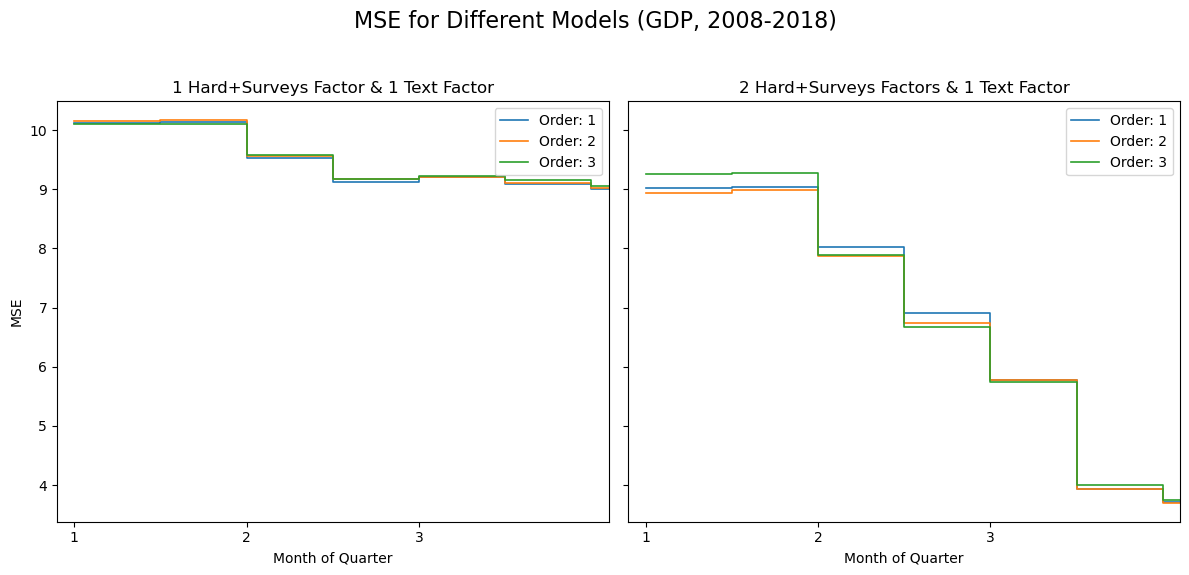

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


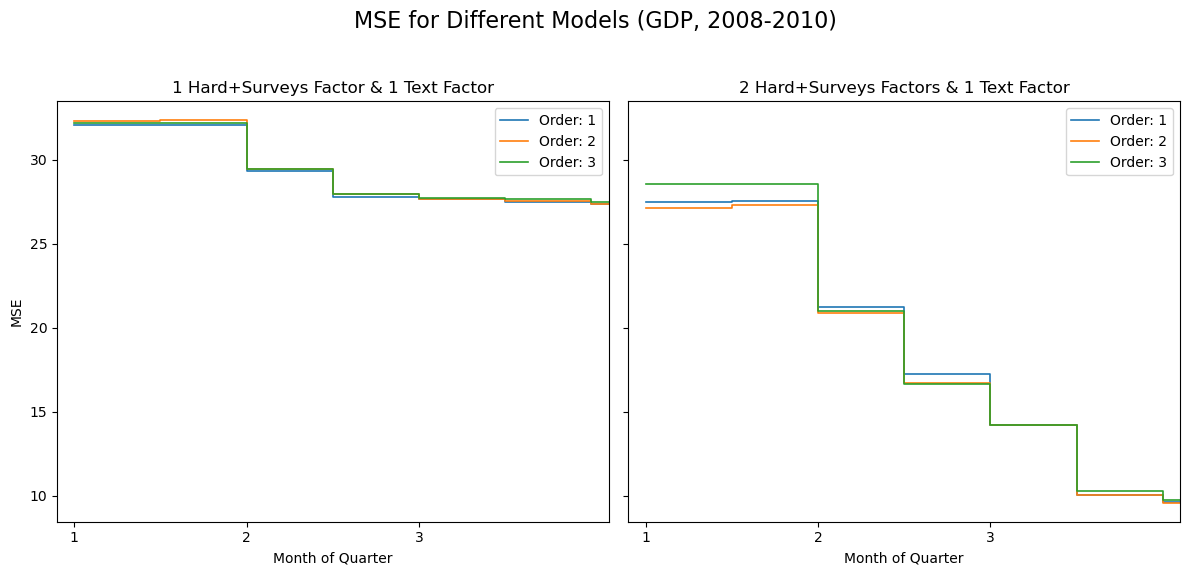

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


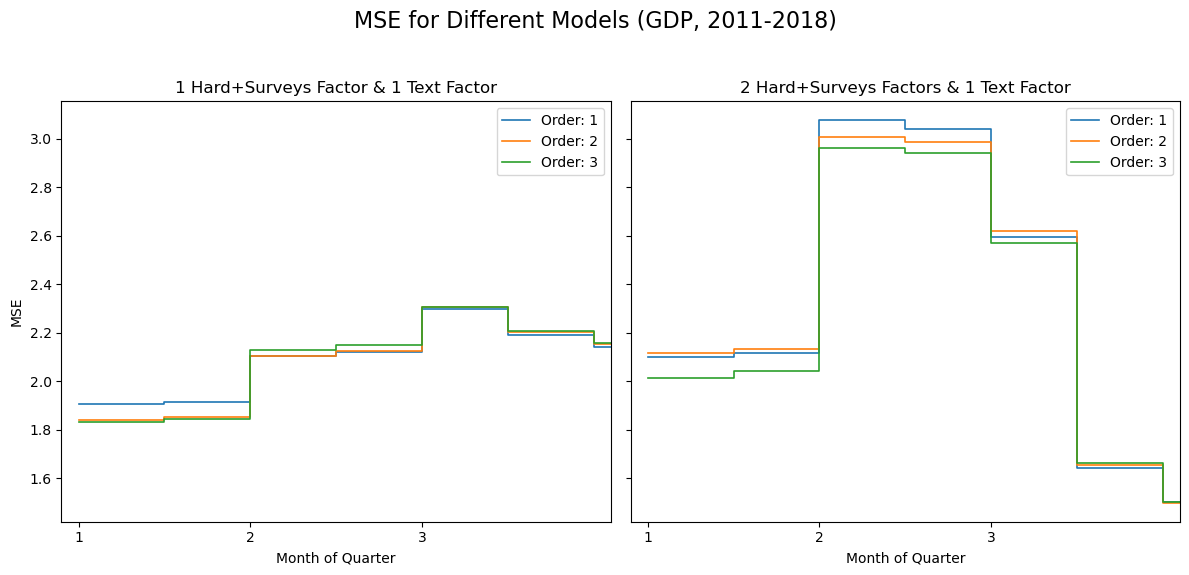

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_GDP_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


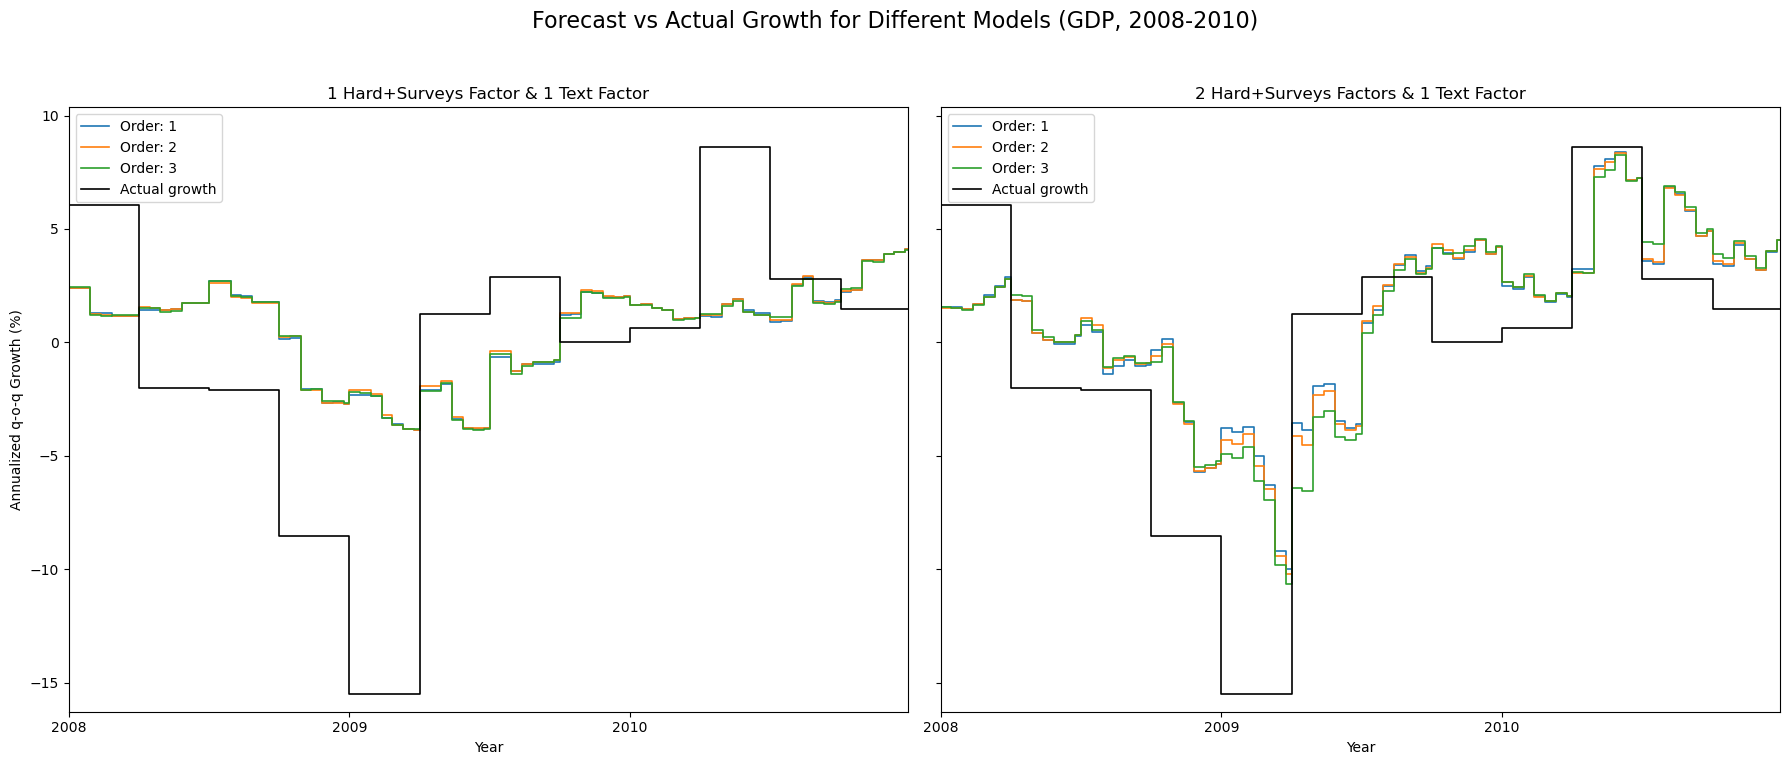

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


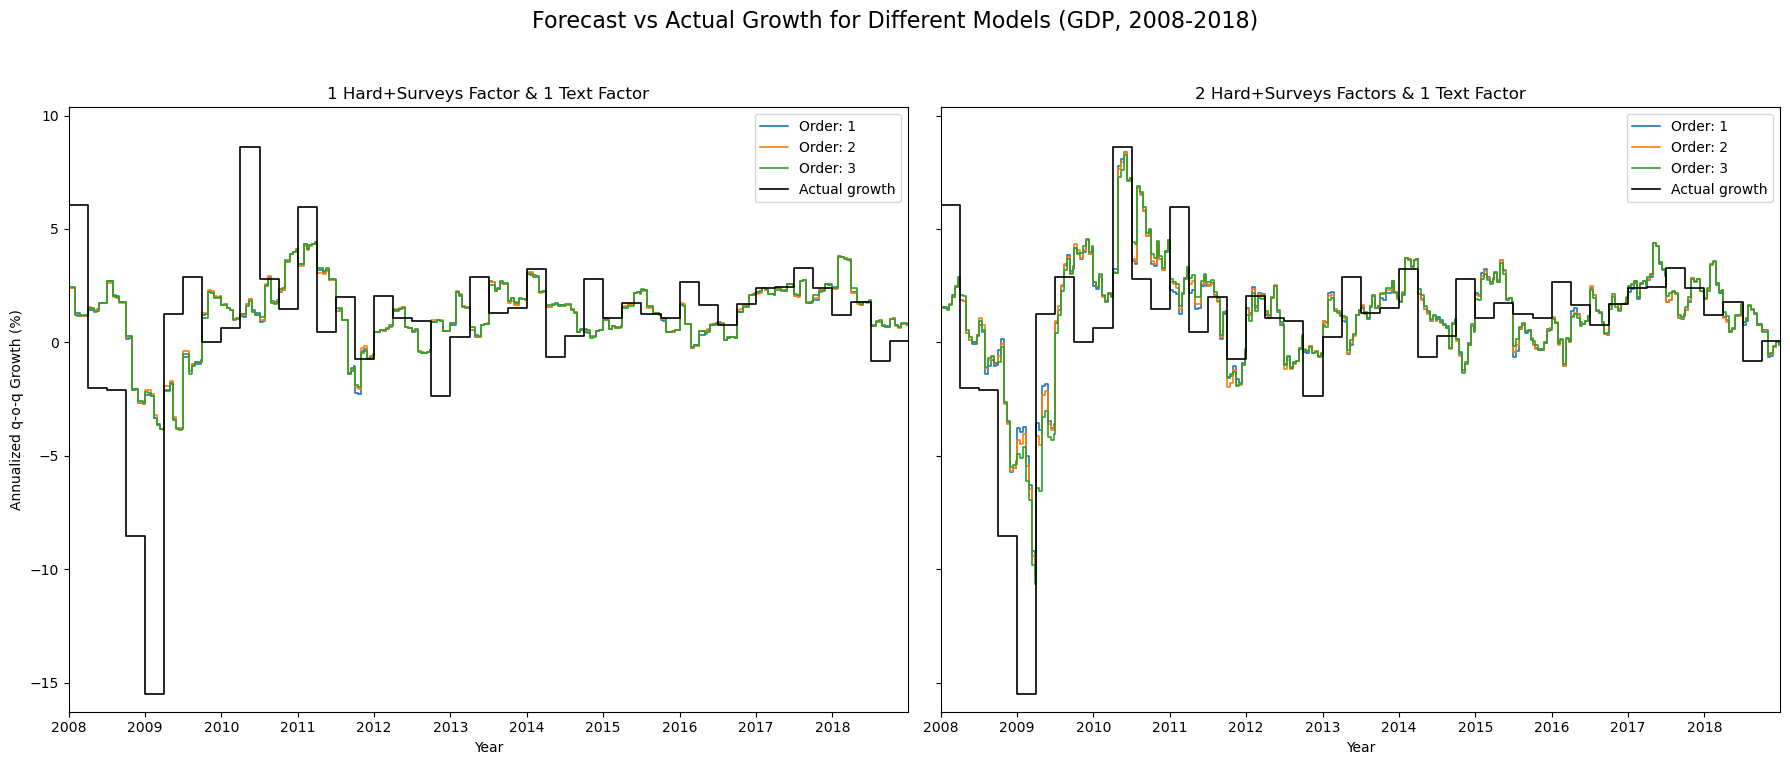

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


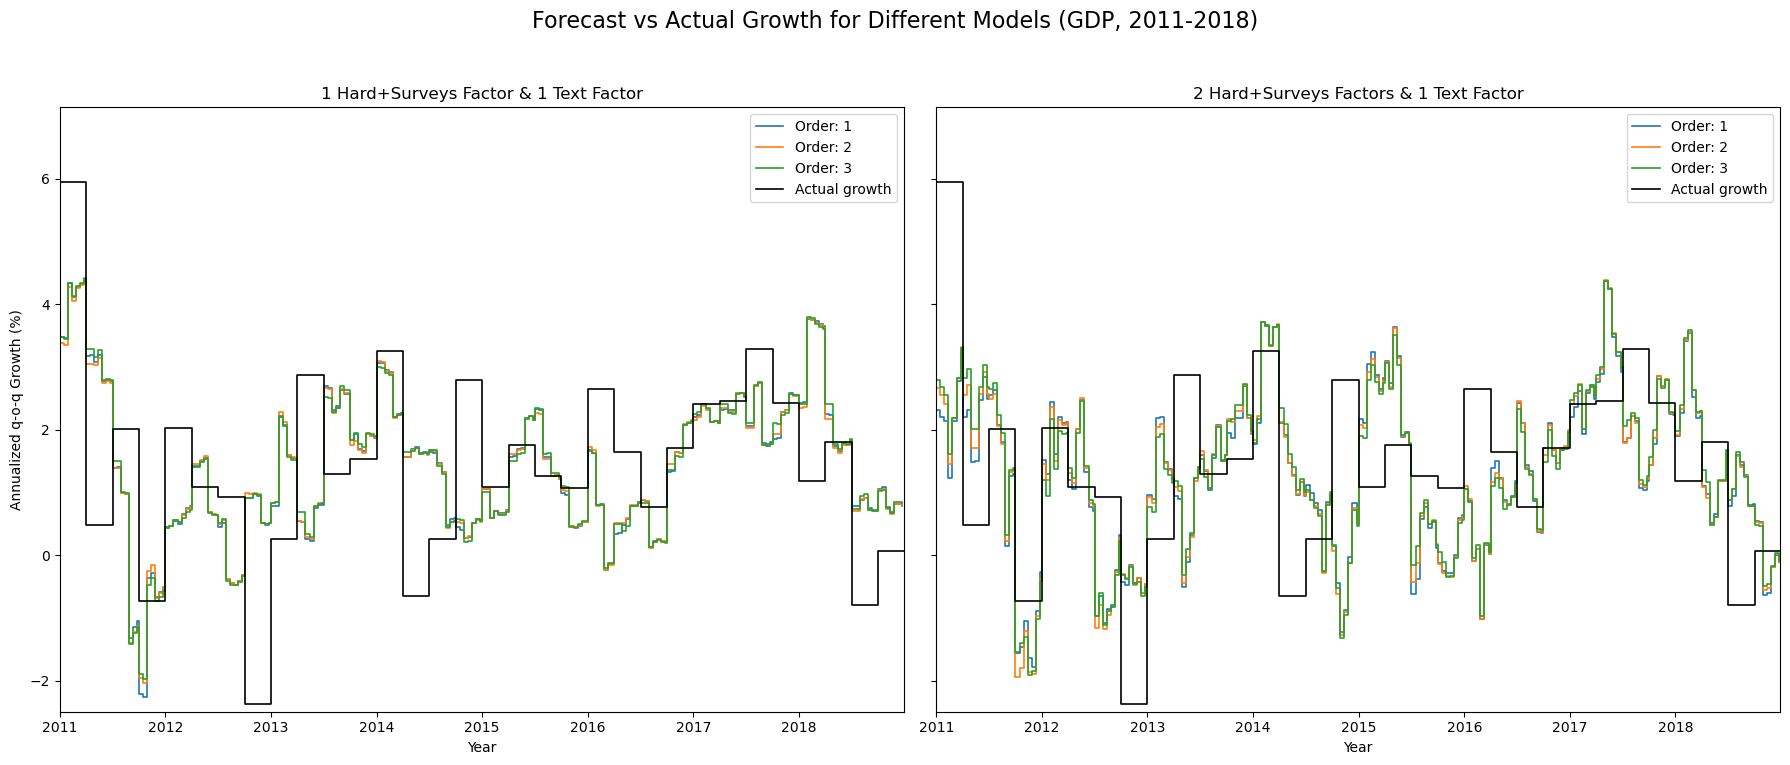

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_GDP_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()